In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Load Libraries & Data 

In [1]:
from fastai import *
from fastai.tabular.all import *

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', low_memory=False, index_col='Id')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', low_memory=False, index_col='Id')

# 2. Data Pre-Processing

<AxesSubplot:>

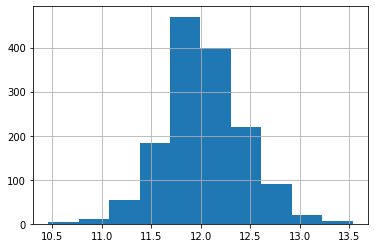

In [3]:
df['SalePrice'] = np.log(df['SalePrice'])
df['SalePrice'].hist()

In [4]:
def processing_pass1(df):
    qual_order = 'Po', 'Fa', 'TA', 'Gd', 'Ex'
    exp_order = 'No', 'Mn', 'Av', 'Gd'
    bsmt_finish_order = 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'
    garage_finish_order = 'Unf', 'RFn', 'Fin'

    df['BsmtExposure'] = df['BsmtExposure'].astype('category')
    df['BsmtExposure'].cat.set_categories(exp_order, ordered=True, inplace=True)

    df['BsmtFinType1'] = df['BsmtFinType1'].astype('category') 
    df['BsmtFinType1'].cat.set_categories(bsmt_finish_order, ordered=True, inplace=True)

    df['BsmtFinType2'] = df['BsmtFinType2'].astype('category') 
    df['BsmtFinType2'].cat.set_categories(bsmt_finish_order, ordered=True, inplace=True)

    df['GarageFinish'] = df['GarageFinish'].astype('category')
    df['GarageFinish'].cat.set_categories(garage_finish_order, ordered=True, inplace=True)

    df['LotShape'] = df['LotShape'].astype('category')
    df['LotShape'].cat.set_categories(['IR1','IR2','IR3'], ordered=True, inplace=True)

    df['LandSlope'] = df['LandSlope'].astype('category')
    df['LandSlope'].cat.set_categories(['Gtl','Mod','Sev'], ordered=True, inplace=True)

    df['Fence'] = df['Fence'].astype('category')
    df['Fence'].cat.set_categories(['MnWw','GdWo','MnPrv','GdPrv'], ordered=True, inplace=True)

    qual_var_list = ['ExterQual','ExterCond','BsmtQual','BsmtCond','KitchenQual','HeatingQC','FireplaceQu',
                     'GarageQual','GarageCond','PoolQC']
    for var in qual_var_list:
        df[var] = df[var].astype('category')
        df[var].cat.set_categories(qual_order, ordered=True, inplace=True)  

    #Missing treatment
    #Creating features based on high missing vars, and will drop the actual var post this
    df['PoolFlag'] = np.where(df['PoolQC'].isnull(),1,0)
    df['ElevatorFlag'] = np.where(df['MiscFeature']=='Elevator',1,0)
    df['TennisCourtFlag'] = np.where(df['MiscFeature']=='TenC',1,0)

    #GarageYrBuilt is missing for houses where there is no garage, 
    #hence it makes sense to replace is with 0 rather than using some other imputing strategy
    df.loc[df['GarageYrBlt'].isnull(),'GarageYrBlt'] = 0

    missing_vars = ['PoolQC','MiscFeature']
    df.drop(columns=missing_vars, inplace=True)
    
    return df

In [5]:
#Feature addition/changes post univariate/bivariate analysis
def processing_pass2(df):
    #Replacing LotFrontage & LotArea with logs
    df['LotFrontage'] = np.log(df['LotFrontage'])
    df['LotArea'] = np.log(df['LotArea'])
    
    #Very few values in garage cars >3 , hence volatile price
    df.loc[df['GarageCars']>3, 'GarageCars'] = 3
    
    #Seems like SalePrice has ordering as per MSZoning
    df['MSZoning'] = df['MSZoning'].astype('category')
    df['MSZoning'].cat.set_categories(['RM','FV','C (all)','RL','RH'], ordered=True, inplace=True)

    #Outlier capping post looking at the univariate/bivariate plots
    df.loc[df['BsmtFinSF1']>5000, 'BsmtFinSF1'] = 5000
    df.loc[df['TotalBsmtSF']>5000, 'TotalBsmtSF'] = 5000
    df.loc[df['1stFlrSF']>5000, '1stFlrSF'] = 5000
    df.loc[df['GrLivArea']>5000, 'GrLivArea'] = 5000

    df.loc[df['LotFrontage']>5.5, 'LotFrontage'] = 5.5
    df.loc[df['LotArea']>11.5, 'LotArea'] = 11.5
    
    #return df

In [6]:
df1 = processing_pass1(df.copy())
processing_pass2(df1)

In [32]:
#final_var_list derived using analysis done earlier using RF feature importance
final_var_list = ['MSZoning', 'Neighborhood', 'CentralAir', 'FireplaceQu', 'GarageFinish', 'LotFrontage', 'LotArea', 
                  'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 
                  'GrLivArea', 'FullBath', 'GarageCars']

df_final = df1[final_var_list+['SalePrice']] 
#df_final = df1.copy()

In [33]:
cont, cat = cont_cat_split(df_final, 1, dep_var='SalePrice')
procs = [Categorify, FillMissing, Normalize]
splitter = RandomSplitter(seed=0)

In [34]:
df_final[cat].nunique()

MSZoning         5
Neighborhood    25
CentralAir       2
FireplaceQu      5
GarageFinish     3
dtype: int64

In [35]:
cont

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'GarageCars']

In [36]:
to_nn = TabularPandas(df_final, procs, cat, cont, y_names='SalePrice', splits=splitter(df))
len(to_nn.train), len(to_nn.valid)

(1168, 292)

In [37]:
dls = to_nn.dataloaders(750 )

In [38]:
dls.show_batch()

,MSZoning,Neighborhood,CentralAir,FireplaceQu,GarageFinish,LotFrontage_na,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice
0,RL,CollgCr,Y,#na#,RFn,False,4.204693,9.190953,7.0,5.0,2002.000000,2002.000000,787.999995,1572.999975,1573.000000,2.0,2.0,12.332705
1,RL,Mitchel,Y,#na#,Unf,False,4.317488,9.434124,6.0,7.0,1939.999999,1985.000000,660.000003,983.000001,1750.000001,2.0,1.0,11.982929
2,RL,NridgHt,Y,Gd,Fin,False,4.859812,9.725377,9.0,5.0,2004.000000,2005.000001,1447.000045,1980.000023,1979.999996,2.0,3.0,12.660328
3,RM,BrkSide,N,#na#,Unf,False,3.931826,8.719317,5.0,7.0,1925.000001,1950.000000,489.000001,767.999996,1015.000004,1.0,1.0,11.385092
4,RL,NoRidge,Y,TA,Fin,False,4.682131,9.600624,9.0,5.0,1999.000001,1999.000000,-0.000022,1392.999996,2599.000003,2.0,3.0,12.716402
5,RL,Sawyer,Y,Gd,Unf,False,4.174387,9.041922,5.0,8.0,1965.000000,2009.000000,553.000000,894.000002,893.999988,1.0,1.0,11.838626
6,FV,Somerst,Y,Gd,RFn,False,4.624973,9.318566,8.0,5.0,2004.000000,2005.000001,-0.000022,1579.999985,2466.000027,3.0,2.0,12.736701
7,RL,NAmes,Y,#na#,Fin,False,4.304065,8.677269,5.0,7.0,1955.999999,2000.000000,247.999998,935.999999,935.999987,1.0,1.0,11.767568
8,RL,NWAmes,Y,TA,Unf,False,3.871201,9.743495,6.0,5.0,1979.000000,1998.000001,-0.000022,1362.000008,1586.000002,2.0,2.0,12.106253
9,RL,SawyerW,Y,#na#,Unf,False,4.158883,8.856234,5.0,5.0,1979.000000,1979.000000,-0.000022,-0.000002,2239.999983,2.0,2.0,11.870271


# 3. Model Training

In [39]:
learn = tabular_learner(dls, y_range=(10,14), metrics=rmse, n_out=1)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.00015848931798245758)

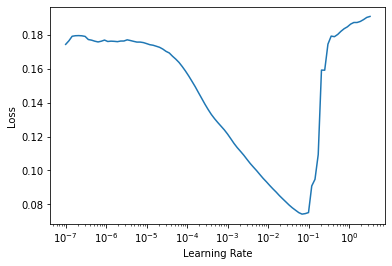

In [29]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(250, 4e-4, wd=0.01)

epoch,train_loss,valid_loss,_rmse,time
0,0.164317,0.176367,0.419961,00:00
1,0.160670,0.176075,0.419613,00:00
2,0.155830,0.175516,0.418946,00:00
3,0.153991,0.174748,0.418029,00:00
4,0.150753,0.173629,0.416688,00:00
5,0.149640,0.172476,0.415302,00:00
6,0.148714,0.171012,0.413536,00:00
7,0.147456,0.169226,0.411371,00:00
8,0.144613,0.167389,0.409132,00:00
9,0.142239,0.165057,0.406272,00:00


### Export the model

In [ ]:
learn.export('nn_model.pkl')

# 5. Prediction

In [ ]:
test = processing_pass1(test_df.copy())
processing_pass2(test)
test.head()

In [ ]:
#additional missing value in test continuous vars which wasnt there in training data
test.loc[test['BsmtFinSF1'].isna(),'BsmtFinSF1'] = 0
test.loc[test['BsmtFinSF2'].isna(),'BsmtFinSF2'] = 0
test.loc[test['BsmtUnfSF'].isna(),'BsmtUnfSF'] = 0
test.loc[test['TotalBsmtSF'].isna(),'TotalBsmtSF'] = 0
test.loc[test['BsmtFullBath'].isna(),'BsmtFullBath'] = 0
test.loc[test['BsmtHalfBath'].isna(),'BsmtHalfBath'] = 0
test.loc[test['GarageCars'].isna(),'GarageCars'] = 0
test.loc[test['GarageArea'].isna(),'GarageArea'] = 0

In [ ]:
test_final = test[final_var_list]

In [ ]:
test_to = to_nn.valid.new(test_final)
test_to.process()

test_dl = dls.valid.new(test_to)
test_dl.show_batch()

In [ ]:
nn_preds = np.exp(learn.get_preds(dl=test_dl)[0].squeeze())

In [ ]:
output = pd.DataFrame({'Id': test.index,
                       'SalePrice': nn_preds})
output.to_csv('submission.csv', index=False)

### Getting the embeddings

In [ ]:
learn.model

In [ ]:
dls.classes

In [ ]:
learn.model.embeds

In [ ]:
learn.model.embeds[0].weight

In [ ]:
w_MSZoning = learn.model.embeds[6].weight
dls.classes['MSZoning'], w_MSZoning
w_MSZoning[to_nn.train.xs['MSZoning'].values]